# Chest X-Ray Vison

## 1. Problem
This notebook is a simple example of using a pre-trained model to classify chest x-rays. The model is trained on the NIH Chest X-Ray dataset, which contains 112,120 images of chest x-rays. The dataset is split into 14 classes, which are:
- Atelectasis
- Cardiomegaly
- Effusion
- Infiltration
- Mass
- Nodule
- Pneumonia
- Pneumothorax
- Consolidation
- Edema
- Emphysema
- Fibrosis
- Pleural_Thickening
- Hernia
- No Finding

When I receive new chest x-rays, I want to be able to quickly classify them into one of these 14 classes. This will help me to quickly identify the most important x-rays to review.

## 2. Data
The data is available on Kaggle at https://www.kaggle.com/nih-chest-xrays/data. and was downloaded and extracted to the data folder.
Data was distributed into 12 directories


## 3. Evaluation
Evaluation is prediction probability of each class for each image. The evaluation metric is the mean average precision at different intersection over union (IoU) thresholds. The model will be evaluated on the test set.


In [3]:
import tensorflow as tf
import tensorflow_hub as hub

tf.__version__ , hub.__version__

('2.11.0', '0.12.0')

## 2. Data exploration / preprocessing

Now we'll prepare the data for the model. We'll do the following:
- Load images paths from the data folder
- Load labels from the data/Data_Entry_2017.csv file and other features
- One-hot encode labels
- Remove nan values if any and remove unused columns
- Split data into train and test sets
- Create tf.data.Dataset from train and test sets

In [4]:
# Dataset was downloaded from https://www.kaggle.com/datasets/nih-chest-xrays/data and extracted to the data folder

# Pandas table of all images (*.png) paths from the data folder
import pandas as pd
import glob

image_paths = glob.glob("data/images_*/images/*.png")
data = pd.DataFrame(image_paths, columns=["image_path"])
# Add column with filename
data["filename"] = data["image_path"].apply(lambda x: x.split("/")[-1])
data.head()

,image_path,filename
0,data/images_006/images/00011723_001.png,00011723_001.png
1,data/images_006/images/00013648_003.png,00013648_003.png
2,data/images_006/images/00011945_002.png,00011945_002.png
3,data/images_006/images/00012342_003.png,00012342_003.png
4,data/images_006/images/00011955_002.png,00011955_002.png


In [5]:
# Concatenation image_paths with data/Data_Entry_2017.csv where filename is the same as first column
data_entry = pd.read_csv("data/Data_Entry_2017.csv")

In [6]:
# row count compare of data and data_entry
print("Images count matches data entries! :)") if data.shape[0] == data_entry.shape[0] else print("Images count doesn't match data entries! :(")

Images count matches data entries! :)


In [7]:
data = pd.merge(data, data_entry, left_on="filename", right_on="Image Index")
data.drop(columns=["filename", "Image Index", "OriginalImage[Width", "Height]", "OriginalImagePixelSpacing[x", "y]", "Unnamed: 11"], inplace=True)

In [8]:
data.head()

,image_path,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position
0,data/images_006/images/00011723_001.png,Atelectasis|Infiltration,1,11723,62,M,AP
1,data/images_006/images/00013648_003.png,No Finding,3,13648,33,M,AP
2,data/images_006/images/00011945_002.png,No Finding,2,11945,33,F,AP
3,data/images_006/images/00012342_003.png,Mass,3,12342,60,M,AP
4,data/images_006/images/00011955_002.png,Effusion|Infiltration,2,11955,54,F,PA


In [9]:
 # Clear nan "Finding Labels"
data.dropna(subset=["Finding Labels"], inplace=True)

In [10]:
from itertools import chain
import numpy as np
# Convert features "Patient Gender", "View Position" to one-hot encoded columns
data = pd.concat([data, pd.get_dummies(data["Patient Gender"], prefix="Patient Gender")], axis=1)
data = pd.concat([data, pd.get_dummies(data["View Position"], prefix="View Position")], axis=1)


# Create disease vector from column 'Finding Labels' containing a disease label or multiple labels separated by '|' on an occasion.
data['Finding Labels'] = data['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
data['Finding Labels'] = data['Finding Labels'].map(lambda x: x.split('|') if len(x)>0 else x)

In [11]:
data.head()

,image_path,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,Patient Gender_F,Patient Gender_M,View Position_AP,View Position_PA
0,data/images_006/images/00011723_001.png,"[Atelectasis, Infiltration]",1,11723,62,M,AP,0,1,1,0
1,data/images_006/images/00013648_003.png,,3,13648,33,M,AP,0,1,1,0
2,data/images_006/images/00011945_002.png,,2,11945,33,F,AP,1,0,1,0
3,data/images_006/images/00012342_003.png,[Mass],3,12342,60,M,AP,0,1,1,0
4,data/images_006/images/00011955_002.png,"[Effusion, Infiltration]",2,11955,54,F,PA,1,0,0,1


In [12]:
# drop empty from l2
unique_diseases = set()
all_findings = []

for plot_data in data['Finding Labels']:
    if plot_data:
        for f in plot_data:
            if f not in unique_diseases:
                unique_diseases.add(f)
                if len(unique_diseases) == 14:
                    break

unique_diseases = sorted(unique_diseases)

data['Disease Vector'] = data['Finding Labels'].map(lambda x: [True if label in x else False for label in unique_diseases])


In [13]:
data.head()

,image_path,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,Patient Gender_F,Patient Gender_M,View Position_AP,View Position_PA,Disease Vector
0,data/images_006/images/00011723_001.png,"[Atelectasis, Infiltration]",1,11723,62,M,AP,0,1,1,0,"[True, False, False, False, False, False, Fals..."
1,data/images_006/images/00013648_003.png,,3,13648,33,M,AP,0,1,1,0,"[False, False, False, False, False, False, Fal..."
2,data/images_006/images/00011945_002.png,,2,11945,33,F,AP,1,0,1,0,"[False, False, False, False, False, False, Fal..."
3,data/images_006/images/00012342_003.png,[Mass],3,12342,60,M,AP,0,1,1,0,"[False, False, False, False, False, False, Fal..."
4,data/images_006/images/00011955_002.png,"[Effusion, Infiltration]",2,11955,54,F,PA,1,0,0,1,"[False, False, False, False, True, False, Fals..."


In [14]:
# Nan values per column
data.isna().sum()

image_path          0
Finding Labels      0
Follow-up #         0
Patient ID          0
Patient Age         0
Patient Gender      0
View Position       0
Patient Gender_F    0
Patient Gender_M    0
View Position_AP    0
View Position_PA    0
Disease Vector      0
dtype: int64

In [15]:
# How many images are there in each class?
def decode_vector(vector):
    if not any(vector):
        return ['No Finding']
    dv = [unique_diseases[i] for i, x in enumerate(vector) if x == 1]
    return dv if len(dv) > 0 else ['No Finding']

[decode_vector(v) for v in data['Disease Vector'].head()]

[['Atelectasis', 'Infiltration'],
 ['No Finding'],
 ['No Finding'],
 ['Mass'],
 ['Effusion', 'Infiltration']]

In [16]:
decode_vector([0]*14)

['No Finding']

In [17]:
# summarize vectors from column 'Disease Vector' into summary vector
stack = np.vstack([np.array(v) for v in data['Disease Vector']])
sum_vector = np.sum(stack, axis=0)

that's a lot of samples! great!

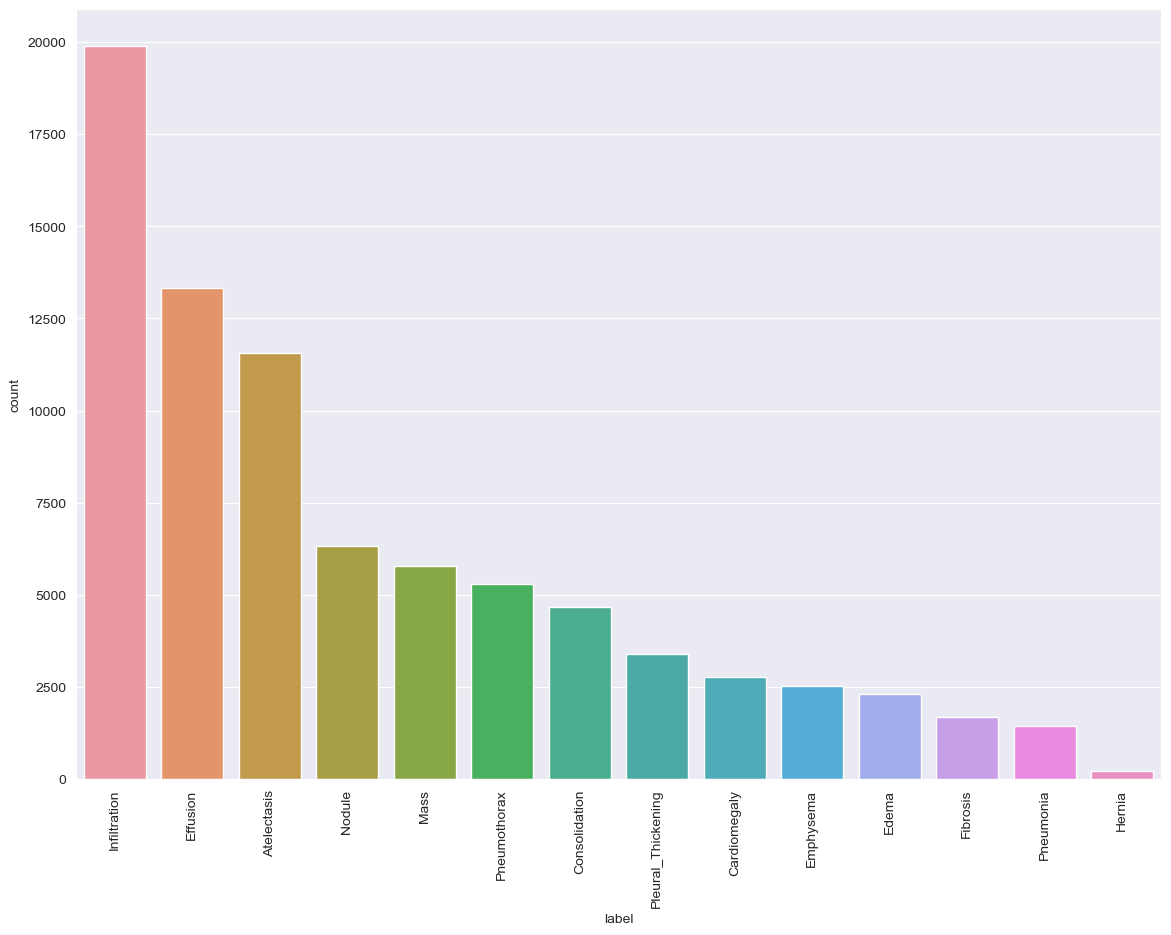

In [18]:
# Plot sum of each class in the dataset. Label columns are [8:]. Sorted by sum. Seaborn bar-plot.

import seaborn as sns
import matplotlib.pyplot as plt

plot_data = pd.DataFrame([[k, v] for k, v in zip(unique_diseases, sum_vector)], columns=['label', 'count']).sort_values(by=['count'], ascending=False)

# display d as a bar plot sorted by values in descending order
plt.figure(figsize=(14, 10))
sns.barplot(y="count", x="label", data=plot_data)
plt.xticks(rotation=90)
plt.show();


In [19]:
data.drop('Finding Labels', axis=1, inplace=True)

In [20]:
data.shape

(112120, 11)

In [21]:
# Split data into train and test sets

X = data.iloc[:, 0:10]
y = data.iloc[:, 10:11]
y = y['Disease Vector'].apply(lambda x: np.array(list(x)))

In [22]:
X.head()

,image_path,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,Patient Gender_F,Patient Gender_M,View Position_AP,View Position_PA
0,data/images_006/images/00011723_001.png,1,11723,62,M,AP,0,1,1,0
1,data/images_006/images/00013648_003.png,3,13648,33,M,AP,0,1,1,0
2,data/images_006/images/00011945_002.png,2,11945,33,F,AP,1,0,1,0
3,data/images_006/images/00012342_003.png,3,12342,60,M,AP,0,1,1,0
4,data/images_006/images/00011955_002.png,2,11955,54,F,PA,1,0,0,1


In [23]:
y.head()

0    [True, False, False, False, False, False, Fals...
1    [False, False, False, False, False, False, Fal...
2    [False, False, False, False, False, False, Fal...
3    [False, False, False, False, False, False, Fal...
4    [False, False, False, False, True, False, Fals...
Name: Disease Vector, dtype: object

/var/folders/x3/1n2vh61953d6j7tdrlv7_y4h0000gn/T/ipykernel_91160/2859278241.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.iloc[:, 1:].corr(),


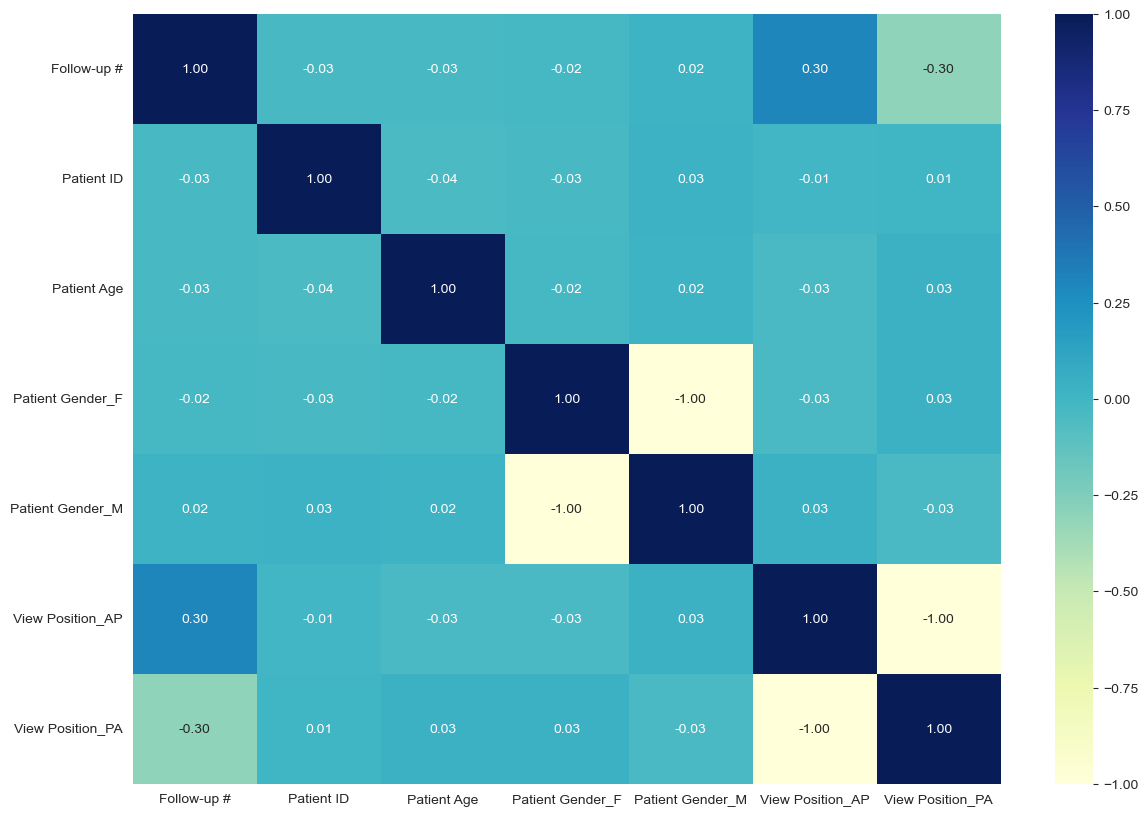

In [24]:
# Correlation matrix of image_paths

plt.figure(figsize=(14, 10))
sns.heatmap(data.iloc[:, 1:].corr(),
            annot=True,
            fmt=".2f",
            cmap="YlGnBu")
plt.show();

In [25]:
# set image count for modeling (for faster training)
IMAGE_COUNT = 1000

In [26]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X[:IMAGE_COUNT],
                                                      np.array(y[:IMAGE_COUNT]),
                                                      test_size=0.2,
                                                      random_state=42)

len(X_train), len(X_valid), len(y_train), len(y_valid)

(800, 200, 800, 200)

### Preprocessing images

To preprocess images into Tensors one's going to write a function which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our image (convert RGB values from 0-255 to 0-1).
5. Resize the `image` to be a shape of (224, 224)
6. Return the modified `image`

In [27]:
IMG_SIZE = 224

import tensorflow as tf

def process_image(image_path, img_size=IMG_SIZE):
    """
    Create a function to preprocess images using tensorflow
    Load grayscale image with image_path as Tensor
    Turn image into Tensor
    Convert to RGB
    Convert to 0-255 to 0-1
    Resize image to [img_size, img_size]
    :param image_path: Image filepath
    :param img_size: Image size
    :return: Preprocessed image
    """
    # Read in an image file using
    img =tf.io.read_file(image_path)
    # decode grayscale png
    img = tf.image.decode_png(img, channels=3)
    # convert [0-255] to [0-1]
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize image
    img = tf.image.resize(img, size=[img_size, img_size])

    return img

In [28]:
# Let's test function with a random image
image = process_image(X_train["image_path"].iloc[0]);

Metal device set to: Apple M1 Pro


2023-02-10 18:33:11.055979: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-10 18:33:11.056343: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


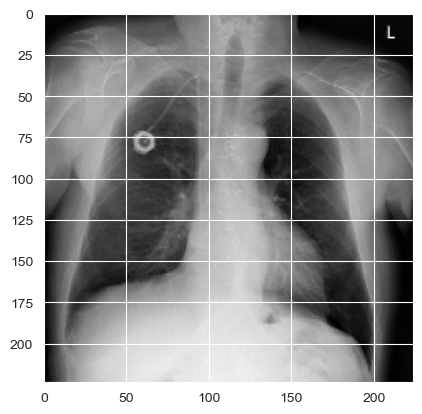

In [29]:
image
# display image
plt.imshow(image)

### Creating data batches

To create data batches, one's going to use the `tf.data` module which can help speed up our modelling process.

Since we're dealing with image data, it's a good idea to read our data in order. There are two main methods we can use to do this:

* `tf.data.Dataset.from_tensor_slices()` - Reads in data from slices (in our case, slices of an array of image paths and labels).

In [30]:
def get_image_label(image_path, label):
    """
    Get image and label
    :param image_path: Image filepath
    :param label: Image label
    :return: Image and label
    """
    image = process_image(image_path)
    return image, label

In [31]:
tpl = get_image_label(X_train.iloc[79]["image_path"], y_train[79])
tpl

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.03529412, 0.03529412, 0.03529412],
         [0.03529412, 0.03529412, 0.03529412],
         [0.03529412, 0.03529412, 0.03529412],
         ...,
         [0.0471194 , 0.0471194 , 0.0471194 ],
         [0.16418687, 0.16418687, 0.16418687],
         [0.39318117, 0.39318117, 0.39318117]],
 
        [[0.03529412, 0.03529412, 0.03529412],
         [0.03529412, 0.03529412, 0.03529412],
         [0.03529412, 0.03529412, 0.03529412],
         ...,
         [0.04397811, 0.04397811, 0.04397811],
         [0.15926476, 0.15926476, 0.15926476],
         [0.38099644, 0.38099644, 0.38099644]],
 
        [[0.03529412, 0.03529412, 0.03529412],
         [0.03529412, 0.03529412, 0.03529412],
         [0.03529412, 0.03529412, 0.03529412],
         ...,
         [0.04397811, 0.04397811, 0.04397811],
         [0.15574323, 0.15574323, 0.15574323],
         [0.380396  , 0.380396  , 0.380396  ]],
 
        ...,
 
        [[0.24970132, 0.24970132

In [32]:
# Define batch size
BATCH_SIZE = 32
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    """
    Creates batches of data out of image (X) and label (y) pairs.
    Shuffles the data if it's training data but doesn't shuffle if it's validation data.
    Also accepts test data as input (no labels).
    """
    # If the data is a test dataset, we probably don't have labels

    y = list(y)

    if test_data:
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X["image_path"]))) # only filepaths (no labels)
        data_batch = data.map(process_image).batch(batch_size)
        return data_batch

    # If the data is a valid dataset, we don't need to shuffle it
    elif valid_data:
        print("Creating validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X["image_path"]), # filepaths
                                                   tf.constant(y))) # labels
        data_batch = data.map(get_image_label).batch(batch_size)
        return data_batch

    else:
        # If the data is a training dataset, we want to shuffle it
        print("Creating training data batches...")
        # Turn filepaths and labels into Tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X["image_path"]), # filepaths
                                                   tf.constant(y))) # labels
        # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
        data = data.shuffle(buffer_size=len(X))

        # Create (image, label) tuples (this also turns the image path into a preprocessed image)
        data = data.map(get_image_label)

        # Turn the data into batches
        data_batch = data.batch(batch_size)
        return data_batch


In [33]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
valid_data = create_data_batches(X_valid, y_valid, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [34]:
# Check out the different attributes of our data batches
train_data.element_spec, valid_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 14), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 14), dtype=tf.bool, name=None)))

### Visualizing training data batches

To visualize training data batches, one's going to write a function which does a few things:
1. Take a batch of images and labels from a training dataset as input
2. Unpack the batch into images and labels
3. Plot the images and labels in a grid
4. Return the plotted grid
5. Plot a single image and label from a training dataset
6. Return the plotted image and label
7. Plot a batch of images and labels from a training dataset
8. Return the plotted grid
9. Plot a batch of images and labels from a validation dataset
10. Return the plotted grid
11. Plot a batch of images and labels from a test dataset
12. Return the plotted grid

In [35]:
def get_conditions(label):
    """
    Get conditions from labels
    :param label:
    :return: Conditions string
    """
    return "|".join(decode_vector(label))

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Create a function for viewing images in a data batch
def show_n_images(images, labels, n=25):
    """
    Displays a plot of images with their labels.
    :param images: Image
    :param labels: Labels
    :param n: Number of images to display
    :return: Plot of images and labels
    """
    # Create a figure with subplots
    x = int(np.ceil(n / 5))
    plt.figure(figsize=(10, int(10*n/25)))
    # Loop through n (for displaying 25 images)
    for i in range(n):
        # Create subplots (x rows, 5 columns)
        ax = plt.subplot(x, 5, i+1)
        # Display an image
        plt.imshow(images[i])
        # Add the image label as the title
        title = get_conditions(labels[i])
        plt.title(title, fontsize=8)
        # Turn the grid lines off
        plt.axis("off")
        plt.tight_layout()
    plt.show()

2023-02-10 18:33:11.425024: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


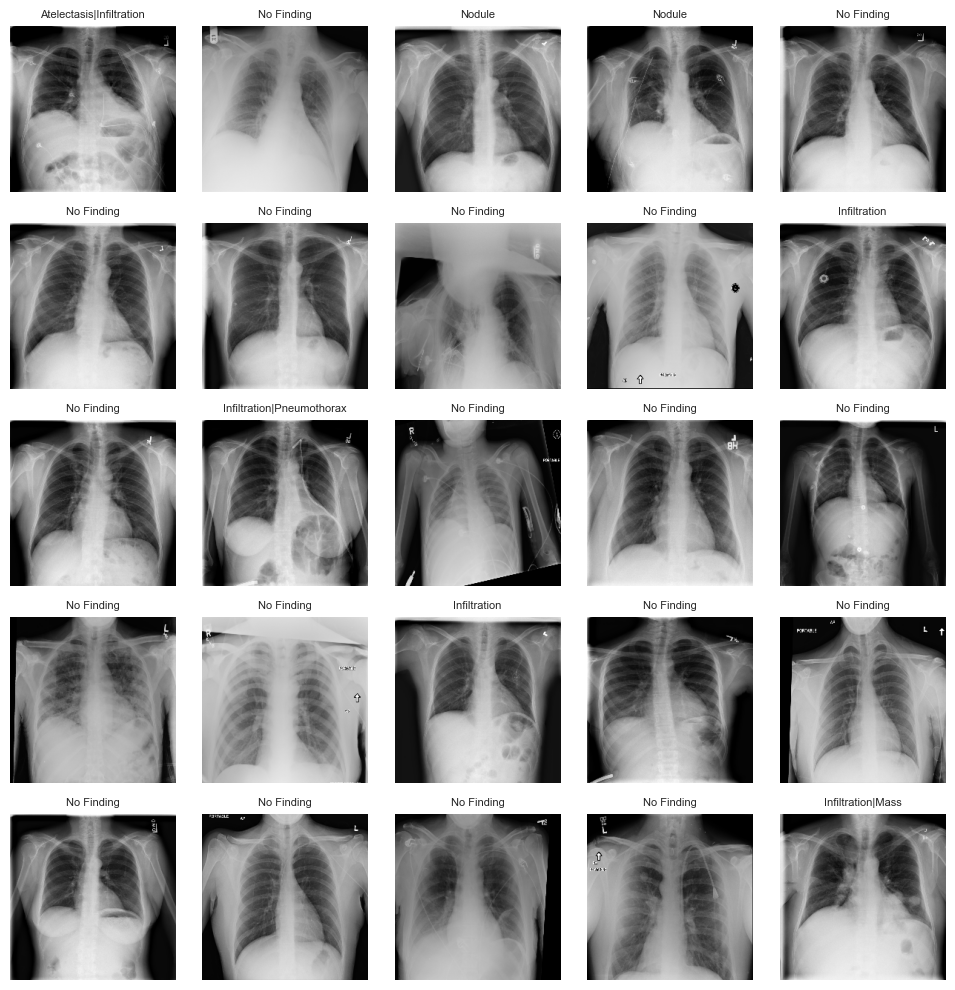

In [37]:
# Now let's visualize a batch of training data
images, labels = next(train_data.as_numpy_iterator())
show_n_images(images, labels, 25);

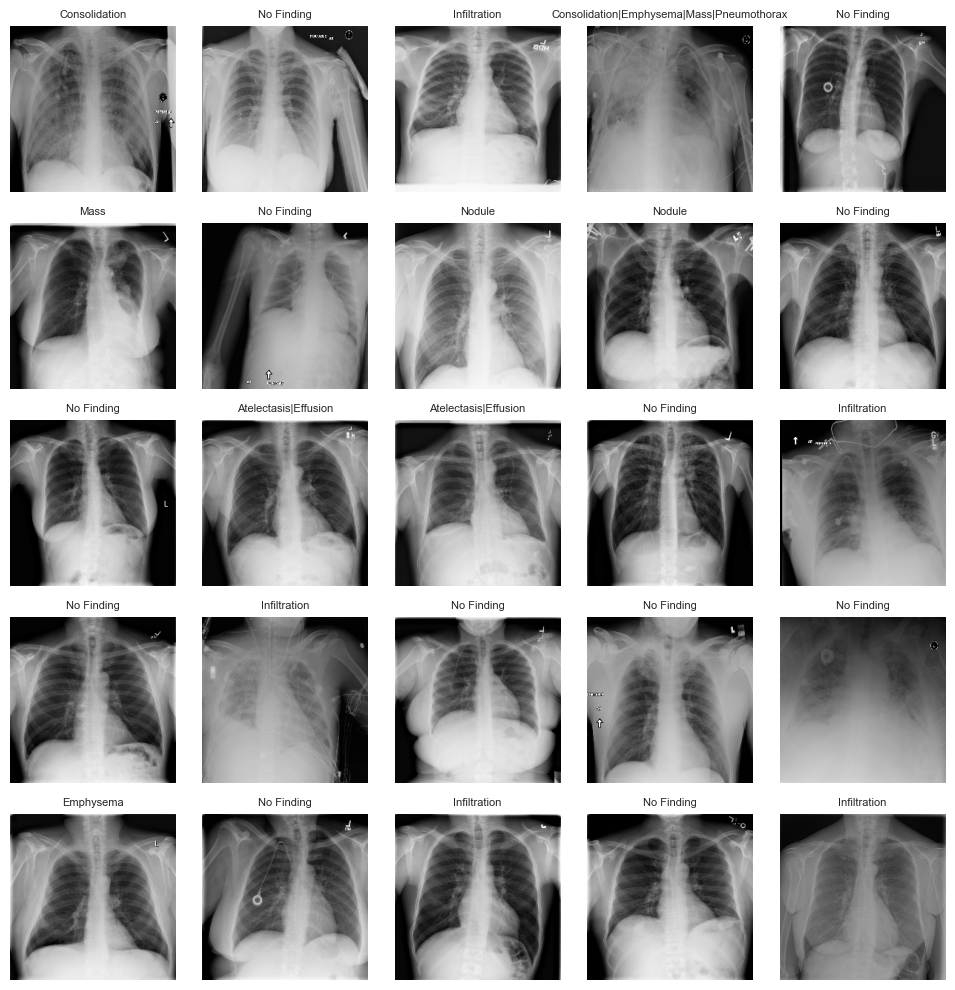

In [38]:
# Now let's visualize our validation set
val_images, val_labels = next(valid_data.as_numpy_iterator())
show_n_images(val_images, val_labels, 25);

In [39]:
INPUT_SHAPE = [None, 224, 224, 3]
OUTPUT_SHAPE = len(unique_diseases)
# best pretrained model for chest x-ray images 14-classes classification
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/classification/5"

In [40]:
import tensorflow as tf
import tensorflow_hub as hub

In [41]:
import tensorflow as tf
import tensorflow_hub as hub

# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL, hidden_layer=128):

    # Download the pretrained model and save it as a Keras layer
    keras_layer = hub.KerasLayer(model_url,
                                 trainable=False, # freeze the already learned patterns
                                 name="inputs", # name the layer
                                 input_shape=input_shape[1:]) # input shape to the model

    model = tf.keras.Sequential([
        keras_layer,
        tf.keras.layers.Dense(hidden_layer, activation="relu"),
        tf.keras.layers.Dense(output_shape, activation="sigmoid", name="outputs")
    ])

    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), # updated optimizer to the latest version
        metrics=['accuracy']
    )

    model.build(input_shape)

    return model



In [42]:
from tensorflow import keras


def create_model_2(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE):

    model = keras.Sequential()
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape[1:]))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(output_shape, activation='softmax'))



    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # updated optimizer to the latest version
        metrics=['accuracy']
    )

    model.build(input_shape)

    return model

In [43]:
model = create_model_2()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

### Model checkpoint, tensorboard saving logs, early stopping callback

In [44]:
import datetime

# Create a model checkpoint callback which saves the model's weights only
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor='val_loss',
                                                      save_weights_only=True,
                                                      save_best_only=True,
                                                      verbose=1)


# Create a model saving logs callback for tensorboard
log_dir = "data/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      histogram_freq=2)

# Create early stopping callback model = fit_model();
# loss,categorical_accuracy,val_loss,val_categorical_accuracy
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=10,
                                                  start_from_epoch=25)

### Training model (on a subset of data)

We'll train our model on a subset of data (IMAGE_COUNT=1000) to see how it performs.

In [45]:
# Setting NUM_EPOCHS
NUM_EPOCHS = 100

In [46]:
# Check which GPU is available
print("GPU", "available (YAY!)" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU available (YAY!)


Let's create functions to trains our model

1. Call create_model()
2. Set our callbacks: early_stopping / tensorboard_callback / model_checkpoint
3. Fit the model on the subset of the training data
4. Returns the model

In [47]:
# Build a function to train and return a trained model
def fit_model():
    """
    Let’s create functions to trains our model
    Call create_model()
    Set our callbacks: early_stopping / tensorboard_callback / model_checkpoint
    Fit the model on the subset of the training data

    :return: Returns the model
    """

    # Create the model
    model = create_model()

    # Fit the model to the data passing it the callbacks we created
    model.fit(train_data,
              epochs=NUM_EPOCHS,
              validation_data=valid_data,
              validation_freq=1,
              callbacks=[tensorboard_callback, early_stopping, model_checkpoint])

    return model

In [48]:
# Fit the model to the data
model = fit_model();

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Epoch 1/100


2023-02-10 18:34:31.708248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - ETA: 0s - loss: 1.6827 - accuracy: 0.1925

2023-02-10 18:34:34.839613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 1.80969, saving model to model_checkpoints/cp.ckpt
25/25 [==============================] - 7s 216ms/step - loss: 1.6827 - accuracy: 0.1925 - val_loss: 1.8097 - val_accuracy: 0.0950
Epoch 2/100
25/25 [==============================] - ETA: 0s - loss: 1.4362 - accuracy: 0.2362
Epoch 2: val_loss improved from 1.80969 to 1.74582, saving model to model_checkpoints/cp.ckpt
25/25 [==============================] - 3s 134ms/step - loss: 1.4362 - accuracy: 0.2362 - val_loss: 1.7458 - val_accuracy: 0.0950
Epoch 3/100
25/25 [==============================] - ETA: 0s - loss: 1.3813 - accuracy: 0.2362
Epoch 3: val_loss did not improve from 1.74582
25/25 [==============================] - 4s 158ms/step - loss: 1.3813 - accuracy: 0.2362 - val_loss: 1.7548 - val_accuracy: 0.3050
Epoch 4/100
25/25 [==============================] - ETA: 0s - loss: 1.3019 - accuracy: 0.2725
Epoch 4: val_loss did not improve from 1.74582
25/25 [==============================] - 3s

In [50]:
%tensorboard --logdir "/Users/blazej.przybyszewski/Desktop/src/chest-xray-classification/data/logs"

UsageError: Line magic function `%tensorboard` not found.
